# 🎯 Customer Clustering - Model Training

This notebook trains multiple clustering models to group customers based on their features.

**Dataset Context:** Customer segmentation for marketing and business strategy

## Models to Train:
1. **K-Means Clustering** - Popular partitioning algorithm
2. **Mini-Batch K-Means** - Faster variant for large datasets
3. **Agglomerative Hierarchical Clustering** - Bottom-up approach
4. **DBSCAN** - Density-based clustering
5. **Gaussian Mixture Model (GMM)** - Probabilistic clustering
6. **Spectral Clustering** - Graph-based approach

## Evaluation Metrics:
- **Silhouette Score** - Cluster cohesion and separation (-1 to 1, higher is better)
- **Calinski-Harabasz Index** - Variance ratio (higher is better)
- **Davies-Bouldin Index** - Average similarity between clusters (lower is better)
- **Inertia** - Sum of squared distances to cluster centers (K-Means only)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime
import time

# Clustering algorithms
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Dimensionality reduction for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Load Processed Data

In [6]:
# Load the scaled dataset (StandardScaler version recommended)
print("Loading processed clustering data...\n")

df = pd.read_csv('clustering_scaled_standard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1]}")
print(f"Samples: {df.shape[0]:,}")
print(f"\nFirst few rows:")
df.head()

Loading processed clustering data...

Dataset shape: (8636, 17)
Features: 17
Samples: 8,636

First few rows:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.744625,-0.370047,-0.429184,-0.359160,-0.354826,-0.468655,-0.820769,-0.686280,-0.717179,-0.681953,-0.479437,-0.517623,-0.962575,-0.543942,-0.305508,-0.537727,0.355181
1,0.764152,0.067679,-0.473208,-0.359160,-0.458839,2.568556,-1.236139,-0.686280,-0.926522,0.557022,0.099258,-0.597054,0.677204,0.796852,0.087689,0.212380,0.355181
2,0.426602,0.505405,-0.116413,0.099909,-0.458839,-0.468655,1.256077,2.646651,-0.926522,-0.681953,-0.479437,-0.120467,0.813852,-0.399503,-0.099906,-0.537727,0.355181
3,-0.373910,0.505405,-0.465825,-0.349660,-0.458839,-0.468655,-1.028455,-0.408536,-0.926522,-0.681953,-0.479437,-0.557339,-0.907916,-0.380165,-0.261131,-0.537727,0.355181
4,0.099551,0.505405,0.142062,-0.359160,0.994815,-0.468655,0.425339,-0.686280,0.538882,-0.681953,-0.479437,-0.279329,-0.743938,-0.132119,0.650363,-0.537727,0.355181


## 🔍 Determine Optimal Number of Clusters

We'll use multiple methods to find the optimal k:
1. **Elbow Method** - Find the "elbow" in inertia curve
2. **Silhouette Analysis** - Maximize silhouette score

In [7]:
# Prepare data
X = df.values

print(f"Data shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]:,}")

Data shape: (8636, 17)
Features: 17
Samples: 8,636


In [21]:
# Check for and handle missing values
print("Checking data quality...\n")

print(f"Missing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found!")

# Check for NaN or inf values
has_nan = df.isnull().values.any()
has_inf = np.isinf(df.values).any()

if has_nan:
    print(f"\n⚠️  WARNING: Found {df.isnull().sum().sum()} missing values!")
    print("Filling missing values with column means...")
    df = df.fillna(df.mean())
    print("✓ Missing values handled")

if has_inf:
    print(f"\n⚠️  WARNING: Found infinite values!")
    print("Replacing infinite values...")
    df = df.replace([np.inf, -np.inf], np.nan).fillna(df.mean())
    print("✓ Infinite values handled")

# Ensure all columns are numeric
non_numeric = df.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\n⚠️  WARNING: Found non-numeric columns: {list(non_numeric)}")
    print("These columns will be excluded from clustering.")
    df = df.select_dtypes(include=[np.number])

print(f"\n✓ Final dataset shape: {df.shape}")
print("✓ Data quality check complete!")

Checking data quality...

Missing values per column:
No missing values found!

✓ Final dataset shape: (8636, 17)
✓ Data quality check complete!


In [8]:
# Elbow Method and Silhouette Analysis
print("="*80)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    print(f"\nTesting k={k}...")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"  Inertia: {inertia:.2f}")
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Calinski-Harabasz: {calinski:.2f}")
    print(f"  Davies-Bouldin: {davies_bouldin:.4f}")

print("\n✓ Cluster analysis complete!")

FINDING OPTIMAL NUMBER OF CLUSTERS

Testing k=2...
  Inertia: 123282.40
  Silhouette: 0.2082
  Calinski-Harabasz: 1647.89
  Davies-Bouldin: 1.9121

Testing k=3...
  Inertia: 108086.49
  Silhouette: 0.2471
  Calinski-Harabasz: 1546.53
  Davies-Bouldin: 1.6054

Testing k=4...
  Inertia: 95646.59
  Silhouette: 0.1970
  Calinski-Harabasz: 1539.21
  Davies-Bouldin: 1.5767

Testing k=5...
  Inertia: 88346.24
  Silhouette: 0.1921
  Calinski-Harabasz: 1427.96
  Davies-Bouldin: 1.5506

Testing k=6...
  Inertia: 81696.84
  Silhouette: 0.2077
  Calinski-Harabasz: 1375.68
  Davies-Bouldin: 1.4893

Testing k=7...
  Inertia: 76441.99
  Silhouette: 0.2203
  Calinski-Harabasz: 1323.93
  Davies-Bouldin: 1.3880

Testing k=8...
  Inertia: 71580.44
  Silhouette: 0.2271
  Calinski-Harabasz: 1295.44
  Davies-Bouldin: 1.3625

Testing k=9...
  Inertia: 67095.62
  Silhouette: 0.2319
  Calinski-Harabasz: 1281.22
  Davies-Bouldin: 1.2872

Testing k=10...
  Inertia: 65575.55
  Silhouette: 0.2142
  Calinski-Haraba

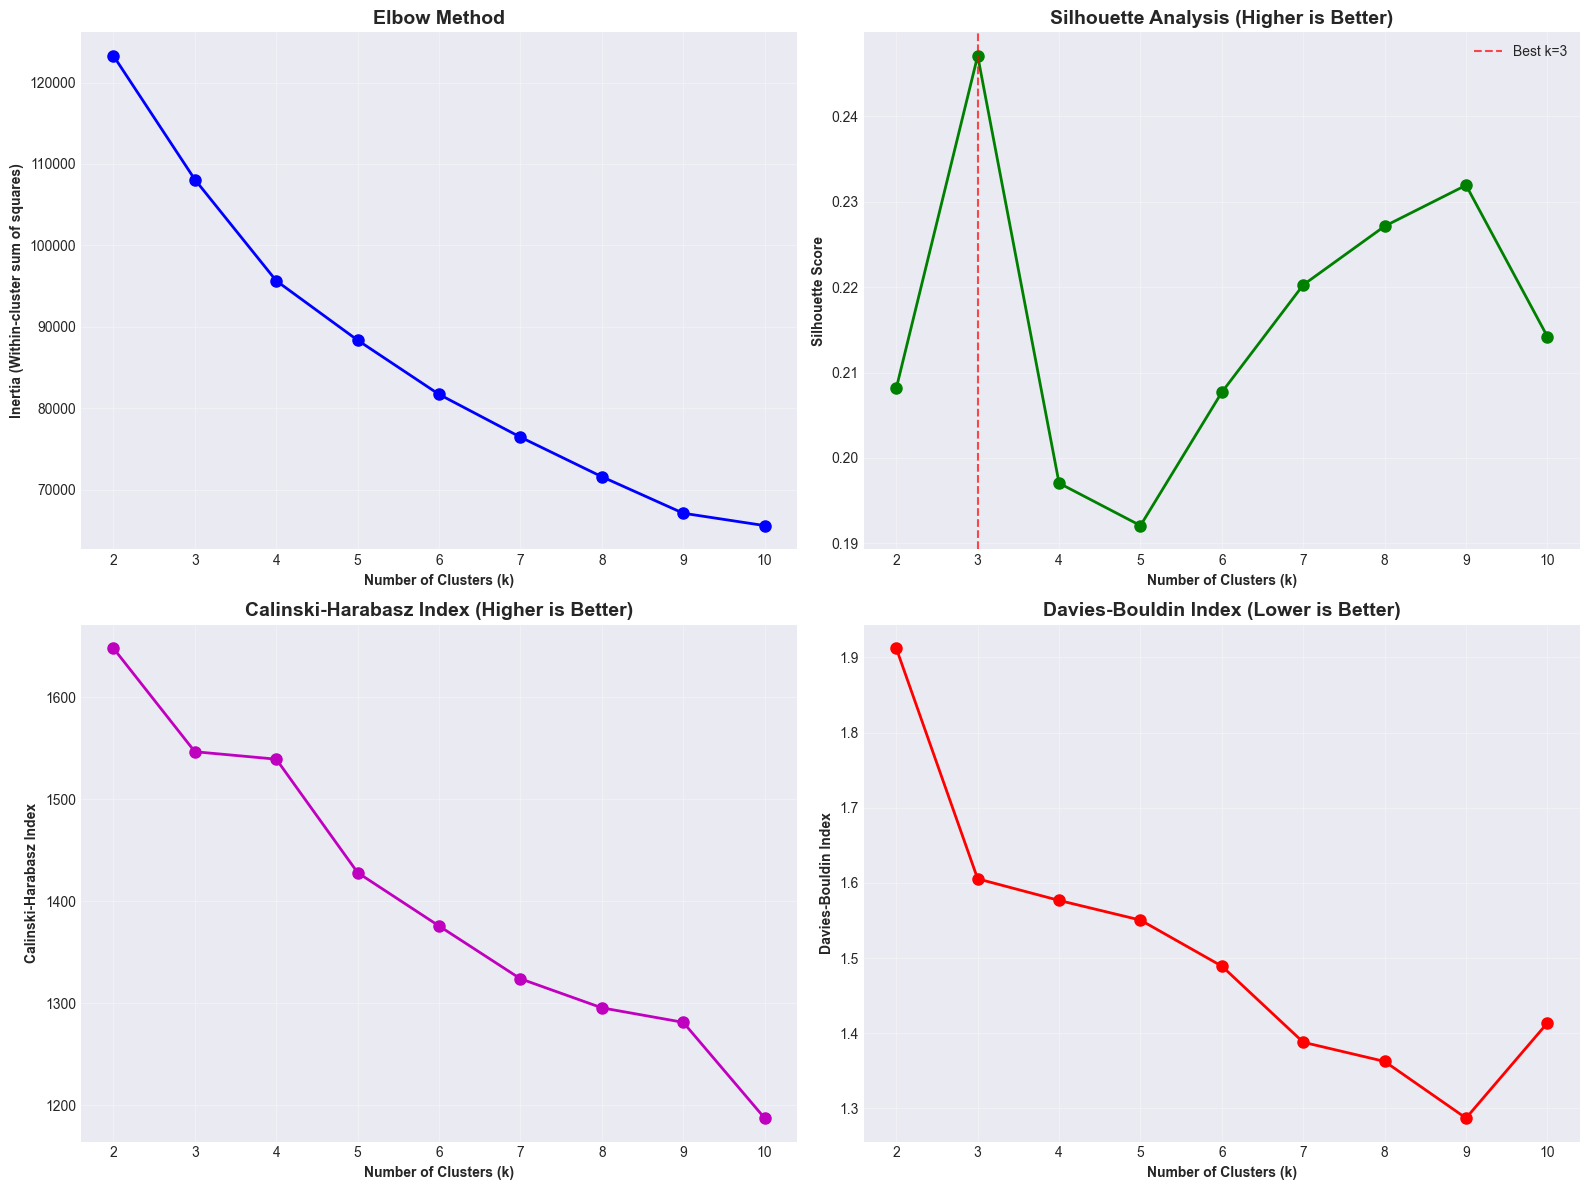


✓ Analysis saved as 'optimal_clusters_analysis.png'

📊 Recommended k based on Silhouette Score: 3


In [9]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Elbow Method
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(k_range)

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontweight='bold')
axes[0, 1].set_title('Silhouette Analysis (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(k_range)

# Mark best k
best_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_silhouette}')
axes[0, 1].legend()

# 3. Calinski-Harabasz Index
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontweight='bold')
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(k_range)

# 4. Davies-Bouldin Index
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontweight='bold')
axes[1, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(k_range)

plt.tight_layout()
plt.savefig('optimal_clusters_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Analysis saved as 'optimal_clusters_analysis.png'")
print(f"\n📊 Recommended k based on Silhouette Score: {best_k_silhouette}")

In [10]:
# Set optimal k for training
optimal_k = best_k_silhouette

print("="*80)
print(f"OPTIMAL NUMBER OF CLUSTERS: k = {optimal_k}")
print("="*80)
print(f"This value will be used for clustering algorithms that require k parameter.")

OPTIMAL NUMBER OF CLUSTERS: k = 3
This value will be used for clustering algorithms that require k parameter.


## Define Evaluation Function

In [11]:
def evaluate_clustering(X, labels, model_name, training_time, model=None):
    """
    Evaluate clustering model performance
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*80}")
    
    # Number of clusters
    n_clusters = len(np.unique(labels[labels >= 0]))  # Exclude noise points (-1)
    n_noise = np.sum(labels == -1)
    
    # Calculate metrics
    if n_clusters > 1 and n_noise < len(labels):  # Need at least 2 clusters
        # For DBSCAN, exclude noise points
        mask = labels >= 0
        X_clean = X[mask]
        labels_clean = labels[mask]
        
        if len(np.unique(labels_clean)) > 1:
            silhouette = silhouette_score(X_clean, labels_clean)
            calinski = calinski_harabasz_score(X_clean, labels_clean)
            davies_bouldin = davies_bouldin_score(X_clean, labels_clean)
        else:
            silhouette = -1
            calinski = 0
            davies_bouldin = float('inf')
    else:
        silhouette = -1
        calinski = 0
        davies_bouldin = float('inf')
    
    # Get inertia for K-Means models
    inertia = model.inertia_ if hasattr(model, 'inertia_') else None
    
    # Print results
    print(f"\n📊 Clustering Results:")
    print(f"   Number of Clusters: {n_clusters}")
    if n_noise > 0:
        print(f"   Noise Points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")
    print(f"   Training Time: {training_time:.2f} seconds")
    
    print(f"\n📈 Evaluation Metrics:")
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Calinski-Harabasz Index: {calinski:.2f}")
    print(f"   Davies-Bouldin Index: {davies_bouldin:.4f}")
    if inertia is not None:
        print(f"   Inertia: {inertia:.2f}")
    
    # Cluster size distribution
    unique, counts = np.unique(labels[labels >= 0], return_counts=True)
    print(f"\n📦 Cluster Sizes:")
    for cluster_id, count in zip(unique, counts):
        print(f"   Cluster {cluster_id}: {count:,} samples ({count/len(labels)*100:.2f}%)")
    
    return {
        'model_name': model_name,
        'model': model,
        'labels': labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'training_time': training_time,
        'silhouette_score': silhouette,
        'calinski_harabasz_score': calinski,
        'davies_bouldin_score': davies_bouldin,
        'inertia': inertia
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


## Train Clustering Models

### 1. K-Means Clustering

In [12]:
# K-Means Clustering
print("Training K-Means Clustering...")

start_time = time.time()
kmeans_model = KMeans(
    n_clusters=optimal_k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans_labels = kmeans_model.fit_predict(X)
kmeans_time = time.time() - start_time

kmeans_results = evaluate_clustering(X, kmeans_labels, 'K-Means', kmeans_time, kmeans_model)

# Save model
with open('model_kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)
print("\n✓ Model saved: model_kmeans.pkl")

Training K-Means Clustering...

Evaluating: K-Means

📊 Clustering Results:
   Number of Clusters: 3
   Training Time: 0.09 seconds

📈 Evaluation Metrics:
   Silhouette Score: 0.2471
   Calinski-Harabasz Index: 1546.53
   Davies-Bouldin Index: 1.6054
   Inertia: 108086.49

📦 Cluster Sizes:
   Cluster 0: 1,567 samples (18.14%)
   Cluster 1: 5,857 samples (67.82%)
   Cluster 2: 1,212 samples (14.03%)

✓ Model saved: model_kmeans.pkl


### 2. Mini-Batch K-Means

In [13]:
# Mini-Batch K-Means (faster for large datasets)
print("Training Mini-Batch K-Means...")

start_time = time.time()
minibatch_kmeans_model = MiniBatchKMeans(
    n_clusters=optimal_k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    batch_size=1000,
    random_state=42
)
minibatch_labels = minibatch_kmeans_model.fit_predict(X)
minibatch_time = time.time() - start_time

minibatch_results = evaluate_clustering(X, minibatch_labels, 'Mini-Batch K-Means', minibatch_time, minibatch_kmeans_model)

# Save model
with open('model_minibatch_kmeans.pkl', 'wb') as f:
    pickle.dump(minibatch_kmeans_model, f)
print("\n✓ Model saved: model_minibatch_kmeans.pkl")

Training Mini-Batch K-Means...

Evaluating: Mini-Batch K-Means

📊 Clustering Results:
   Number of Clusters: 3
   Training Time: 0.03 seconds

📈 Evaluation Metrics:
   Silhouette Score: 0.2074
   Calinski-Harabasz Index: 1511.87
   Davies-Bouldin Index: 1.6732
   Inertia: 108982.93

📦 Cluster Sizes:
   Cluster 0: 1,685 samples (19.51%)
   Cluster 1: 1,869 samples (21.64%)
   Cluster 2: 5,082 samples (58.85%)

✓ Model saved: model_minibatch_kmeans.pkl


### 3. Agglomerative Hierarchical Clustering

In [14]:
# Agglomerative Clustering
print("Training Agglomerative Hierarchical Clustering...")

start_time = time.time()
agglomerative_model = AgglomerativeClustering(
    n_clusters=optimal_k,
    linkage='ward'
)
agglomerative_labels = agglomerative_model.fit_predict(X)
agglomerative_time = time.time() - start_time

agglomerative_results = evaluate_clustering(X, agglomerative_labels, 'Agglomerative Clustering', agglomerative_time, agglomerative_model)

# Save model
with open('model_agglomerative.pkl', 'wb') as f:
    pickle.dump(agglomerative_model, f)
print("\n✓ Model saved: model_agglomerative.pkl")

Training Agglomerative Hierarchical Clustering...

Evaluating: Agglomerative Clustering

📊 Clustering Results:
   Number of Clusters: 3
   Training Time: 3.01 seconds

📈 Evaluation Metrics:
   Silhouette Score: 0.1785
   Calinski-Harabasz Index: 1296.05
   Davies-Bouldin Index: 1.7848

📦 Cluster Sizes:
   Cluster 0: 3,168 samples (36.68%)
   Cluster 1: 4,346 samples (50.32%)
   Cluster 2: 1,122 samples (12.99%)

✓ Model saved: model_agglomerative.pkl


### 4. DBSCAN (Density-Based)

In [15]:
# DBSCAN - Density-based clustering
print("Training DBSCAN...")

start_time = time.time()
dbscan_model = DBSCAN(
    eps=0.5,
    min_samples=5,
    metric='euclidean',
    n_jobs=-1
)
dbscan_labels = dbscan_model.fit_predict(X)
dbscan_time = time.time() - start_time

dbscan_results = evaluate_clustering(X, dbscan_labels, 'DBSCAN', dbscan_time, dbscan_model)

# Save model
with open('model_dbscan.pkl', 'wb') as f:
    pickle.dump(dbscan_model, f)
print("\n✓ Model saved: model_dbscan.pkl")

Training DBSCAN...

Evaluating: DBSCAN

📊 Clustering Results:
   Number of Clusters: 36
   Noise Points: 6488 (75.13%)
   Training Time: 0.08 seconds

📈 Evaluation Metrics:
   Silhouette Score: -0.3110
   Calinski-Harabasz Index: 46.63
   Davies-Bouldin Index: 0.9627

📦 Cluster Sizes:
   Cluster 0: 1,689 samples (19.56%)
   Cluster 1: 8 samples (0.09%)
   Cluster 2: 5 samples (0.06%)
   Cluster 3: 17 samples (0.20%)
   Cluster 4: 6 samples (0.07%)
   Cluster 5: 9 samples (0.10%)
   Cluster 6: 173 samples (2.00%)
   Cluster 7: 5 samples (0.06%)
   Cluster 8: 14 samples (0.16%)
   Cluster 9: 8 samples (0.09%)
   Cluster 10: 7 samples (0.08%)
   Cluster 11: 22 samples (0.25%)
   Cluster 12: 4 samples (0.05%)
   Cluster 13: 7 samples (0.08%)
   Cluster 14: 5 samples (0.06%)
   Cluster 15: 19 samples (0.22%)
   Cluster 16: 5 samples (0.06%)
   Cluster 17: 7 samples (0.08%)
   Cluster 18: 11 samples (0.13%)
   Cluster 19: 5 samples (0.06%)
   Cluster 20: 13 samples (0.15%)
   Cluster 21: 5 s

### 5. Gaussian Mixture Model (GMM)

In [16]:
# Gaussian Mixture Model
print("Training Gaussian Mixture Model...")

start_time = time.time()
gmm_model = GaussianMixture(
    n_components=optimal_k,
    covariance_type='full',
    max_iter=100,
    random_state=42
)
gmm_model.fit(X)
gmm_labels = gmm_model.predict(X)
gmm_time = time.time() - start_time

gmm_results = evaluate_clustering(X, gmm_labels, 'Gaussian Mixture Model', gmm_time, gmm_model)

# Save model
with open('model_gmm.pkl', 'wb') as f:
    pickle.dump(gmm_model, f)
print("\n✓ Model saved: model_gmm.pkl")

Training Gaussian Mixture Model...

Evaluating: Gaussian Mixture Model

📊 Clustering Results:
   Number of Clusters: 3
   Training Time: 0.37 seconds

📈 Evaluation Metrics:
   Silhouette Score: 0.1151
   Calinski-Harabasz Index: 887.56
   Davies-Bouldin Index: 2.6277

📦 Cluster Sizes:
   Cluster 0: 2,659 samples (30.79%)
   Cluster 1: 3,855 samples (44.64%)
   Cluster 2: 2,122 samples (24.57%)

✓ Model saved: model_gmm.pkl


### 6. Spectral Clustering

In [17]:
# Spectral Clustering
print("Training Spectral Clustering...")

start_time = time.time()
spectral_model = SpectralClustering(
    n_clusters=optimal_k,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42,
    n_jobs=-1
)
spectral_labels = spectral_model.fit_predict(X)
spectral_time = time.time() - start_time

spectral_results = evaluate_clustering(X, spectral_labels, 'Spectral Clustering', spectral_time, spectral_model)

# Save model
with open('model_spectral.pkl', 'wb') as f:
    pickle.dump(spectral_model, f)
print("\n✓ Model saved: model_spectral.pkl")

Training Spectral Clustering...

Evaluating: Spectral Clustering

📊 Clustering Results:
   Number of Clusters: 3
   Training Time: 5.05 seconds

📈 Evaluation Metrics:
   Silhouette Score: 0.1611
   Calinski-Harabasz Index: 1218.02
   Davies-Bouldin Index: 1.7610

📦 Cluster Sizes:
   Cluster 0: 3,454 samples (40.00%)
   Cluster 1: 3,568 samples (41.32%)
   Cluster 2: 1,614 samples (18.69%)

✓ Model saved: model_spectral.pkl


## 📊 Compare All Models

In [18]:
# Collect all results
all_results = [
    kmeans_results,
    minibatch_results,
    agglomerative_results,
    dbscan_results,
    gmm_results,
    spectral_results
]

# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'N_Clusters': r['n_clusters'],
    'Noise_Points': r['n_noise'],
    'Training_Time': f"{r['training_time']:.2f}s",
    'Silhouette': r['silhouette_score'],
    'Calinski-Harabasz': r['calinski_harabasz_score'],
    'Davies-Bouldin': r['davies_bouldin_score']
} for r in all_results])

# Sort by Silhouette Score (descending)
comparison_df = comparison_df.sort_values('Silhouette', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
display(comparison_df)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_silhouette = comparison_df.iloc[0]['Silhouette']
print(f"\n🏆 Best Model: {best_model_name} (Silhouette Score = {best_silhouette:.4f})")

# Save comparison
comparison_df.to_csv('clustering_results.csv', index=False)
print("\n✓ Results saved: clustering_results.csv")


MODEL COMPARISON SUMMARY


,Model,N_Clusters,Noise_Points,Training_Time,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,3,0,0.09s,0.247097,1546.528220,1.605443
1,Mini-Batch K-Means,3,0,0.03s,0.207430,1511.868320,1.673163
2,Agglomerative Clustering,3,0,3.01s,0.178453,1296.052863,1.784822
5,Spectral Clustering,3,0,5.05s,0.161097,1218.024894,1.761050
4,Gaussian Mixture Model,3,0,0.37s,0.115123,887.558601,2.627679
3,DBSCAN,36,6488,0.08s,-0.311034,46.632166,0.962680



🏆 Best Model: K-Means (Silhouette Score = 0.2471)

✓ Results saved: clustering_results.csv


## 📈 Visualize Model Comparison

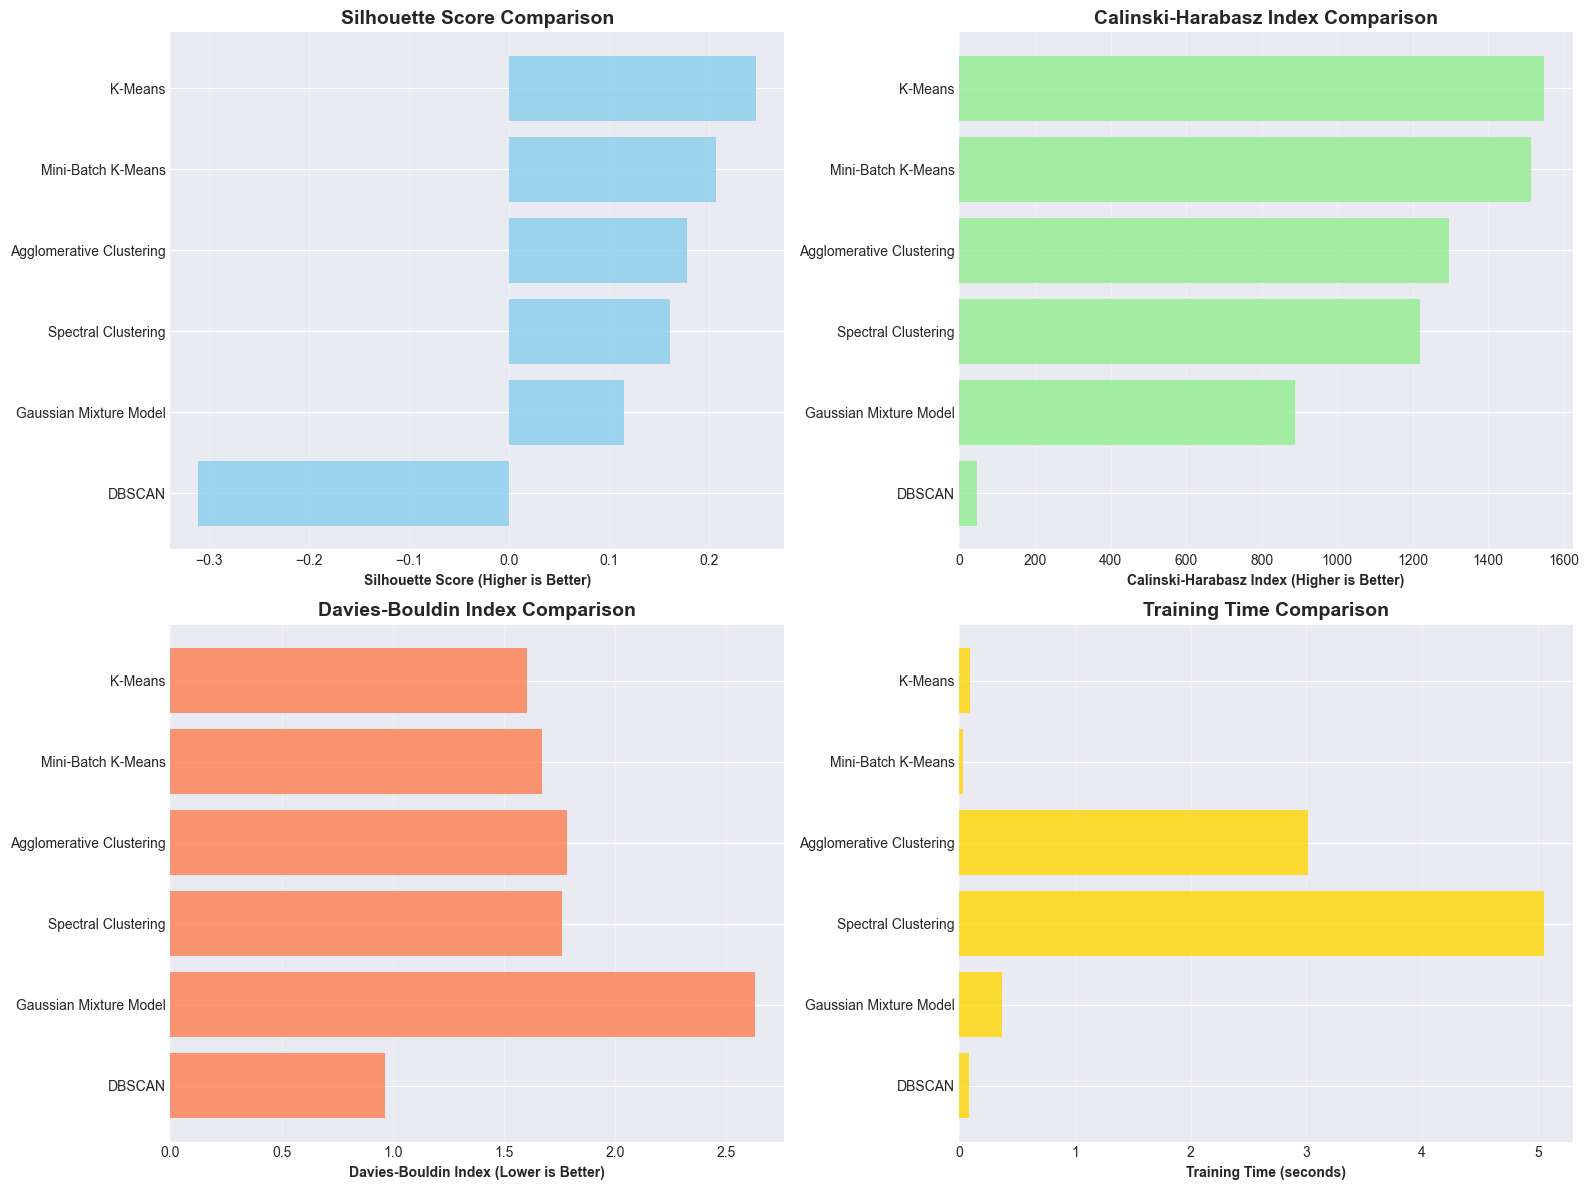


✓ Comparison chart saved as 'clustering_comparison.png'


In [19]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df['Model']

# 1. Silhouette Score
axes[0, 0].barh(models, comparison_df['Silhouette'], color='skyblue', alpha=0.8)
axes[0, 0].set_xlabel('Silhouette Score (Higher is Better)', fontweight='bold')
axes[0, 0].set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Calinski-Harabasz Index
axes[0, 1].barh(models, comparison_df['Calinski-Harabasz'], color='lightgreen', alpha=0.8)
axes[0, 1].set_xlabel('Calinski-Harabasz Index (Higher is Better)', fontweight='bold')
axes[0, 1].set_title('Calinski-Harabasz Index Comparison', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Davies-Bouldin Index
# Filter out infinity values
db_valid = comparison_df[comparison_df['Davies-Bouldin'] != float('inf')]
axes[1, 0].barh(db_valid['Model'], db_valid['Davies-Bouldin'], color='coral', alpha=0.8)
axes[1, 0].set_xlabel('Davies-Bouldin Index (Lower is Better)', fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Index Comparison', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Training Time
training_times = [float(t.replace('s', '')) for t in comparison_df['Training_Time']]
axes[1, 1].barh(models, training_times, color='gold', alpha=0.8)
axes[1, 1].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison chart saved as 'clustering_comparison.png'")

## 💾 Save All Results

In [20]:
# Save all results including labels
print("="*80)
print("SAVING ALL RESULTS")
print("="*80)

# Save results with pickle
with open('all_clustering_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print("✓ All results saved: all_clustering_results.pkl")

# Save labels for each model
labels_df = pd.DataFrame({
    'K-Means': kmeans_labels,
    'Mini-Batch K-Means': minibatch_labels,
    'Agglomerative': agglomerative_labels,
    'DBSCAN': dbscan_labels,
    'GMM': gmm_labels,
    'Spectral': spectral_labels
})
labels_df.to_csv('clustering_labels.csv', index=False)
print("✓ All labels saved: clustering_labels.csv")

print("\n" + "="*80)
print("✅ CLUSTERING TRAINING COMPLETE!")
print("="*80)
print(f"Total models trained: {len(all_results)}")
print(f"Best performing model: {best_model_name}")
print(f"\nFiles created:")
print(f"  • clustering_results.csv - Performance comparison")
print(f"  • clustering_labels.csv - All cluster labels")
print(f"  • all_clustering_results.pkl - Complete results")
print(f"  • model_*.pkl - Individual model files (6 models)")
print(f"  • clustering_comparison.png - Visualization")
print(f"  • optimal_clusters_analysis.png - Optimal k analysis")

SAVING ALL RESULTS
✓ All results saved: all_clustering_results.pkl
✓ All labels saved: clustering_labels.csv

✅ CLUSTERING TRAINING COMPLETE!
Total models trained: 6
Best performing model: K-Means

Files created:
  • clustering_results.csv - Performance comparison
  • clustering_labels.csv - All cluster labels
  • all_clustering_results.pkl - Complete results
  • model_*.pkl - Individual model files (6 models)
  • clustering_comparison.png - Visualization
  • optimal_clusters_analysis.png - Optimal k analysis
